### Installs and Imports

In [1]:
%%capture output
# execute in Colab once per session to install packages
!pip install torchinfo
!pip install pytorch-lightning
!pip install torchmetrics

# uncomment to see output
# print(output)

In [6]:
# imports and settings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import os

from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

from torchinfo import summary

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display

from utils import PrintMetricsCallback, sample_dataset

sns.set_theme()

# Odds and Ends - Transfer Learning and Advanced Training

* Correct Normalization of Data
* PyTorch Lightning Data Modules
* PyTorch Lightning Bolts
* Learning Rate Finders
* Learning Rate Schedulers
* Hyperparameter Tuning?

## Correct Normalization of Data

If you read about using pre-trained models, you'll see that people often normalize their new dataset using the per-channel mean and standard deviation statistics calculated from Imagenet.  

``` imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ```

I did it in our last class when applying a pre-trained Resnet18 model to the Cats and Dogs Kaggle dataset. Although I found that confusing, I followed standard practice.  It was wrong but not harmful since we saw great transfer learning results.

Those statistics are the values used to normalize each channel of the Imagenet data before the model was trained.  Thus, the dataset that the pre-trained model was trained upon had a mean of 0 and a standard deviation of 1 for each RGB channel.  So, suppose you want to fine-tune a pre-trained model using your dataset. In that case, you should normalize each channel of your data using the mean and standard deviation computed from your data as long as you have a reasonably large sample.

Here's some sample code to compute the mean and standard deviation for each channel in the CIFAR-10 dataset:

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Example: Load a dataset (CIFAR10 in this case)
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

# Function to compute mean and std
def compute_mean_std(loader):

    for i,(images,_) in enumerate(loader):
        if i == 0: # initialize
            channels = images.size(1)
            channel_sum, channel_sum_squared = torch.zeros(channels), torch.zeros(channels)
            num_images = 0
            pixels_per_image = images.size(2)*images.size(3)
        num_images += images.size(0)
        channel_sum += images.sum(dim=(0,2,3))/pixels_per_image
        channel_sum_squared += (images ** 2).sum(dim=(0,2,3))/pixels_per_image
        
    # Compute mean and std dev
    mean = channel_sum / num_images
    # Compute variance (mean of squares - square of mean)
    var = (channel_sum_squared / num_images) - (mean ** 2)
    std = torch.sqrt(var)

    return mean, std

# Compute mean and std
mean, std = compute_mean_std(dataloader)

print(f'Mean: {mean}')
print(f'Std: {std}')


Files already downloaded and verified
Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


You might note that those stats for CIFAR-10 aren't that different from the Imagenet stats:
``` imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ```
so using the Imagenet stats is probably fine for most "natural" image datasets.

If you can, you should probably use the statistics for your dataset. Still, if your samples are small or only have a single image you can normalize using the Imagenet stats before applying a pre-trained model.

Normalizing your image data to improve model training is also a good idea, even when training from scratch.  Sometimes, you'll see a mean and standard deviation of 0.5 to shift the [0,1] data from transforms.ToTensor() to the interval [-1,1].  

For standard datasets, we can also use prebuilt Data Modules from Pytorch Lightning Bolts, which already contain the correct normalizations.

## A note about splitting data

The datasets in Torchvision are split into a training set and a non-training set.  We've been using the non-training set as the validation data to monitor how well the model is training, but that isn't good practice and can lead to biased models.  We are deciding to build and train a model based on its performance on the validation set, so we cannot determine if we've done a good job by using the performance on the validation set as a metric.

Using three datasets: training, validation, and test sets is better.  The test set gets used to assess the performance of our model after all training is complete.  This provides an unbiased estimate of the model's performance.  To achieve this with a Torchvision dataset, it's customary to download the training data (`train=True`) and split it into a training set (80% or more) and a validation set.  The test set is then the non-training dataset (`train=False`).

Figure from https://www.v7labs.com/blog/train-validation-test-set

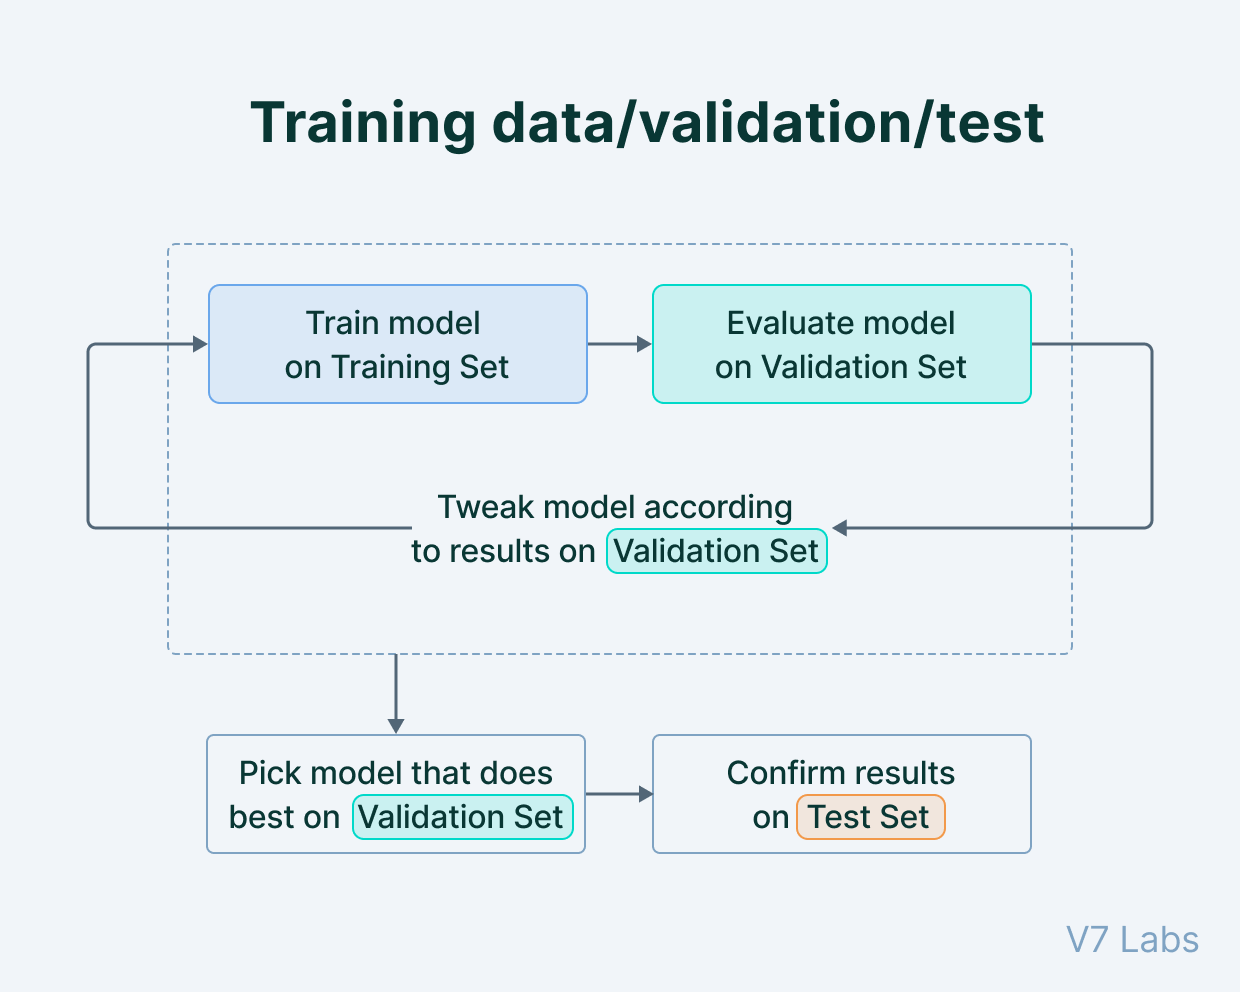

## Splitting the CIFAR-10 Data with training, validation, and test sets

We'll demonstrate how to do the three-way split below and use a Lightning DataModule to encapsulate all the elements of building the dataloaders.  This will have the advantage of making it simple to automatically tune the batch size.

In [8]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=100, 
                 num_sample_each_class=None, seed=42):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_sample_each_class = num_sample_each_class
        self.seed = seed
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.RandomCrop(32, padding=4, padding_mode='reflect')
        ])
        self.train_transform = transforms.Compose([self.augment_transform, self.transform])

    def prepare_data(self):
        # Download the CIFAR10 dataset
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Load and transform the CIFAR10 dataset
        if stage == 'fit' or stage is None:
            cifar10_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            
            if self.num_sample_each_class:
                cifar10_full = sample_dataset(cifar10_full, 
                                              num_samples=num_sample_each_class, 
                                              random_state=self.seed)

            gen_seed = torch.Generator().manual_seed(self.seed)
            self.cifar10_train, self.cifar10_val = random_split(cifar10_full, [45000, 5000], generator=gen_seed)
            self.cifar10_train.dataset.transform = self.train_transform
            self.cifar10_val.dataset.transform = self.transform 
            
        if stage == 'test' or stage is None:
            self.cifar10_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar10_test, batch_size=self.batch_size)

In [9]:
## Instantiate the data module to create the dataloaders

cifar10_dm = CIFAR10DataModule()

## Create or download a model

To make it easy to create new, randomly initialized versions of our network for testing, we've created a function that returns the model:

In [10]:
# CNN + BatchNorm + LeakyReLU

W, H = 32, 32
D = W*H # total pixels
C = 3 # input channels
n_filters = 32 # number of filters in first convolutional block
classes = 10

def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.BatchNorm2d(out_filters), #The only change, adding BatchNorm2d after our convolution!
        nn.LeakyReLU(leak_rate)
    )

def createModel():
    model = nn.Sequential(
        cnnLayer(C, n_filters), cnnLayer(n_filters), cnnLayer(n_filters),
        nn.MaxPool2d((2,2)),
        cnnLayer(n_filters, 2*n_filters), cnnLayer(2*n_filters), cnnLayer(2*n_filters), 
        nn.MaxPool2d((2,2)),
        cnnLayer(2*n_filters, 4*n_filters), cnnLayer(4*n_filters),
        nn.Flatten(),
        nn.Linear(D*n_filters//4, classes),
    )
    return model


We can use a Lightning Trainer to do the test step after training is done.  To do this we'll add a `test_step` to our lighting module.  It's usually the same as the validation step, but not always.  For example, if you were using a strategy called Test Time Augmentation it could be implemented in the `test_step`.  Here is our modified Lightning Module:

In [7]:
import pytorch_lightning as pl
from pytorch_lightning import Callback
from torchmetrics.classification import Accuracy
from utils import PrintMetricsCallback

class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.001): ### Default LR is 0.001

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def test_step(self, batch, batch_idx): ### NEW
        inputs, targets = batch
        outputs = self.net(inputs)
        test_loss = self.loss_func(outputs, targets)
        self.test_acc(outputs, targets)
        self.log_dict( {"test_loss":test_loss,"test_acc":self.test_acc},
                      prog_bar = False)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer


Now lets define a network and train it:

In [38]:
cnn_bn_model = createModel() # create a newly initialized network

light_model = BasicLightningModel(cnn_bn_model, num_classes = 10, lr=0.001)

print_cb = PrintMetricsCallback(print_epoch=1)

trainer = pl.Trainer(max_epochs=15,
                     enable_progress_bar=False,
                     callbacks=[print_cb],
                     num_sanity_val_steps=0,
                     val_check_interval=1.0)

trainer.fit(light_model, cifar10_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 416 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)


Beginning training for at most 15 epochs
Epoch 1 Metrics: valid_loss: 1.0337, valid_acc: 0.6392, train_loss: 1.2207, train_acc: 0.5676, LR: 1.000000e-03
Epoch 2 Metrics: valid_loss: 0.8454, valid_acc: 0.6910, train_loss: 0.8032, train_acc: 0.7186, LR: 1.000000e-03
Epoch 3 Metrics: valid_loss: 0.7598, valid_acc: 0.7262, train_loss: 0.6497, train_acc: 0.7735, LR: 1.000000e-03
Epoch 4 Metrics: valid_loss: 0.7666, valid_acc: 0.7302, train_loss: 0.5426, train_acc: 0.8119, LR: 1.000000e-03
Epoch 5 Metrics: valid_loss: 0.7738, valid_acc: 0.7374, train_loss: 0.4548, train_acc: 0.8443, LR: 1.000000e-03
Epoch 6 Metrics: valid_loss: 0.7730, valid_acc: 0.7550, train_loss: 0.3791, train_acc: 0.8687, LR: 1.000000e-03
Epoch 7 Metrics: valid_loss: 0.7006, valid_acc: 0.7848, train_loss: 0.3124, train_acc: 0.8925, LR: 1.000000e-03
Epoch 8 Metrics: valid_loss: 0.7682, valid_acc: 0.7880, train_loss: 0.2533, train_acc: 0.9111, LR: 1.000000e-03
Epoch 9 Metrics: valid_loss: 0.7395, valid_acc: 0.8026, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15 Metrics: valid_loss: 0.8184, valid_acc: 0.8182, train_loss: 0.0718, train_acc: 0.9748, LR: 1.000000e-03
End.  Trained for 15 epochs.


You could train for longer and run experiments with different models.  When you've finally selected and trained your final model, **then** test it on the test dataset like this:

In [41]:
# Lightning will automatically load the best model from your previous run
trainer.test(light_model, cifar10_dm, ckpt_path='best')

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/Advanced Training/lightning_logs/version_13/checkpoints/epoch=14-step=6750.ckpt
Loaded model weights from the checkpoint at /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/Advanced Training/lightning_logs/version_13/checkpoints/epoch=14-step=6750.ckpt
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8077999949455261
        test_loss           0.8767305612564087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8767305612564087, 'test_acc': 0.8077999949455261}]

## Use a learning rate finder

"For training deep neural networks, selecting a good learning rate is essential for both better performance and faster convergence. Even optimizers such as Adam that are self-adjusting the learning rate can benefit from more optimal choices.

To reduce the amount of guesswork concerning choosing a good initial learning rate, a learning rate finder can be used. As described in [this paper](https://arxiv.org/abs/1506.01186) a learning rate finder does a small run where the learning rate is increased after each processed batch and the corresponding loss is logged. The result of this is a lr vs. loss plot that can be used as guidance for choosing an optimal initial learning rate."

Make sure your LightningModule has an attribute `self.lr` or `self.learning_rate`, and then create and use a Tuner like this:


In [10]:
from pytorch_lightning.tuner import Tuner

cnn_bn_model = createModel() 

light_model = BasicLightningModel(cnn_bn_model, num_classes = 10, lr=0.001)

print_cb = PrintMetricsCallback(print_epoch=1)

trainer = pl.Trainer(max_epochs=15,
                     enable_progress_bar=False,
                     callbacks=[print_cb],
                     num_sanity_val_steps=0,
                     val_check_interval=1.0)

# Create a Tuner
tuner = Tuner(trainer)

# and tune!
tuner.lr_find(light_model, cifar10_dm)

# after running the tuner the learning rate inside your LightningModule will be set to the 
# the suggested value

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Files already downloaded and verified
Files already downloaded and verified


/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
Finding best initial lr:  97%|███████████████████████████████████████████████████████▎ | 97/100 [00:03<00:00, 29.36it/s]
LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/M

You could also get more information about the tuner and manually update the learning rate like this:

Files already downloaded and verified
Files already downloaded and verified


Finding best initial lr:  97%|███████████████████████████████████████████████████████▎ | 97/100 [00:03<00:00, 32.26it/s]
LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/Advanced Training/.lr_find_8c7f21b0-f336-4f08-bd81-0295d2a49e59.ckpt
Restored all states from the checkpoint at /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/Advanced Training/.lr_find_8c7f21b0-f336-4f08-bd81-0295d2a49e59.ckpt
/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_77867/385073135.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

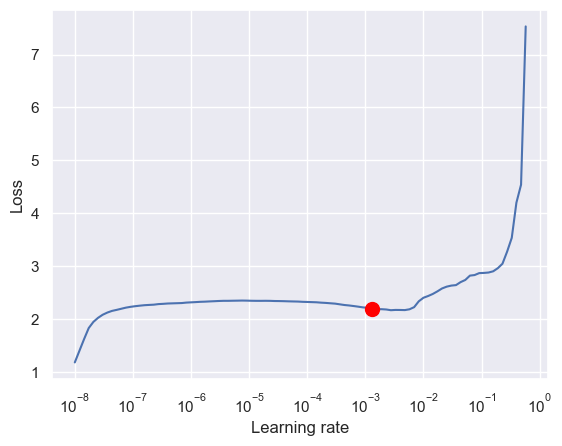

In [11]:
lr_finder = tuner.lr_find(light_model, cifar10_dm)

# results can be found in 
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update our learning rate
light_model.lr = new_lr

# Fit model
# trainer.fit(light_model)

In [16]:
trainer.fit(light_model, train_loader, valid_loader)


  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 416 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)


Beginning training for at most 15 epochs
Epoch 1 Metrics: valid_loss: 1.1882, valid_acc: 0.5750, train_loss: 1.4008, train_acc: 0.4949, LR: 6.309573e-04
Epoch 2 Metrics: valid_loss: 1.0053, valid_acc: 0.6522, train_loss: 0.9928, train_acc: 0.6482, LR: 6.309573e-04
Epoch 3 Metrics: valid_loss: 0.9406, valid_acc: 0.6758, train_loss: 0.8414, train_acc: 0.7037, LR: 6.309573e-04
Epoch 4 Metrics: valid_loss: 1.0119, valid_acc: 0.6674, train_loss: 0.7644, train_acc: 0.7315, LR: 6.309573e-04
Epoch 5 Metrics: valid_loss: 0.9054, valid_acc: 0.7126, train_loss: 0.6945, train_acc: 0.7554, LR: 6.309573e-04
Epoch 6 Metrics: valid_loss: 0.7736, valid_acc: 0.7314, train_loss: 0.6442, train_acc: 0.7762, LR: 6.309573e-04
Epoch 7 Metrics: valid_loss: 0.6095, valid_acc: 0.7862, train_loss: 0.5956, train_acc: 0.7922, LR: 6.309573e-04
Epoch 8 Metrics: valid_loss: 0.7715, valid_acc: 0.7470, train_loss: 0.5536, train_acc: 0.8072, LR: 6.309573e-04
Epoch 9 Metrics: valid_loss: 0.5950, valid_acc: 0.7904, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15 Metrics: valid_loss: 0.6125, valid_acc: 0.7942, train_loss: 0.4166, train_acc: 0.8543, LR: 6.309573e-04
End.  Trained for 15 epochs.


## Tuning batch size

**This is an experimental feature in PyTorch Lightning.  I'm not convinced it works well! **

"Auto-scaling of batch size can be enabled to find the largest batch size that fits into memory. Large batch size often yields a better estimation of the gradients, but may also result in longer training time. Inspired by [https://github.com/BlackHC/toma](https://github.com/BlackHC/toma)."

This feature expects that a batch_size field is either located as a model attribute i.e. `model.batch_size` or as a field in your hparams i.e. `model.hparams.batch_size`. Similarly it can work with datamodules too. The field should exist and will be updated by the results of this algorithm. Additionally, your `train_dataloader()` method should depend on this field for this feature to work

Since we already have a tuner defined from finding a learning rate, we can call the automatic batch size finder like this:

In [12]:
# Auto-scale batch size by growing it exponentially (default)
tuner.scale_batch_size(light_model, cifar10_dm, mode="power", max_trials = 10)

Files already downloaded and verified
Files already downloaded and verified


`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying batch size 64
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 64 succeeded, trying batch size 128
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 128 succeeded, trying batch size 256
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 256 succeeded, trying batch size 512
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 512 succeeded, trying batch size 1024
/Users/jbaggett/miniforge3/envs/UWL-DL/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (44) is smaller than the logg

2048

In [13]:
cifar10_dm.batch_size

2048

In [14]:
light_model.lr

0.0013182567385564075

In [15]:
trainer.fit(light_model, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 416 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)


Beginning training for at most 15 epochs
Epoch 1 Metrics: valid_loss: 2.2333, valid_acc: 0.2252, train_loss: 2.1083, train_acc: 0.2982, LR: 1.318257e-03
Epoch 2 Metrics: valid_loss: 1.3857, valid_acc: 0.4964, train_loss: 1.4116, train_acc: 0.4822, LR: 1.318257e-03
Epoch 3 Metrics: valid_loss: 1.2244, valid_acc: 0.5604, train_loss: 1.1783, train_acc: 0.5756, LR: 1.318257e-03
Epoch 4 Metrics: valid_loss: 1.1241, valid_acc: 0.6078, train_loss: 0.9629, train_acc: 0.6570, LR: 1.318257e-03
Epoch 5 Metrics: valid_loss: 0.8900, valid_acc: 0.6774, train_loss: 0.7950, train_acc: 0.7194, LR: 1.318257e-03
Epoch 6 Metrics: valid_loss: 0.8376, valid_acc: 0.7020, train_loss: 0.6770, train_acc: 0.7618, LR: 1.318257e-03
Epoch 7 Metrics: valid_loss: 0.9362, valid_acc: 0.6786, train_loss: 0.5887, train_acc: 0.7965, LR: 1.318257e-03
Epoch 8 Metrics: valid_loss: 0.7335, valid_acc: 0.7460, train_loss: 0.5249, train_acc: 0.8167, LR: 1.318257e-03
Epoch 9 Metrics: valid_loss: 0.7550, valid_acc: 0.7454, train_l

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15 Metrics: valid_loss: 1.2203, valid_acc: 0.6886, train_loss: 0.3150, train_acc: 0.8866, LR: 1.318257e-03
End.  Trained for 15 epochs.


## Learning Rate Schedulers

You can add learning rate schedulers in the configure_optimizers part of your Lightning Module.  Here, we show how to add a cyclic learning rate scheduler.  You must specify the minimum and maximum learning rates.  It defaults to a triangular shape that cycles every 4000 steps (a step is training on one batch).  [Documentation here](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html).

We'll modify our `BasicLightningModel` class.  Note that there are 45,000 images in the training data so with a batch size of 225 we'll take 45,000/220 = 200 steps per epoch.  If we set step_size_up = 600, then a cycle will be of length 1200 and will take 6 epochs.    

In [11]:
class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.001): ### Default LR is 0.001

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def test_step(self, batch, batch_idx): ### NEW
        inputs, targets = batch
        outputs = self.net(inputs)
        test_loss = self.loss_func(outputs, targets)
        self.test_acc(outputs, targets)
        self.log_dict( {"test_loss":test_loss,"test_acc":self.test_acc},
                      prog_bar = False)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = {'scheduler': CyclicLR(optimizer, base_lr = 0.0005, max_lr = 0.003, 
                                           step_size_up = 600, cycle_momentum=False),
             'interval': 'step', 'frequency': 1}
        return [optimizer],[scheduler]


In [12]:
from torch.optim.lr_scheduler import CyclicLR

cnn_bn_model = createModel() # create a newly initialized network

## re-instantiate the data module to use batch_size = 225
cifar10_dm = CIFAR10DataModule(batch_size = 225)

light_model = BasicLightningModel(cnn_bn_model, num_classes = 10, lr=0.001) # lr doesn't matter

print_cb = PrintMetricsCallback(print_epoch=1)

trainer = pl.Trainer(max_epochs=18,
                     enable_progress_bar=False,
                     callbacks=[print_cb],
                     num_sanity_val_steps=0,
                     val_check_interval=1.0)

trainer.fit(light_model, cifar10_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 416 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)


Beginning training for at most 18 epochs
Epoch 1 Metrics: valid_loss: 1.0477, valid_acc: 0.6442, train_loss: 1.2428, train_acc: 0.5597, LR: 1.333333e-03
Epoch 2 Metrics: valid_loss: 0.9692, valid_acc: 0.6738, train_loss: 0.8686, train_acc: 0.6991, LR: 2.166667e-03
Epoch 3 Metrics: valid_loss: 0.9717, valid_acc: 0.6664, train_loss: 0.7141, train_acc: 0.7536, LR: 3.000000e-03
Epoch 4 Metrics: valid_loss: 0.6823, valid_acc: 0.7748, train_loss: 0.5450, train_acc: 0.8092, LR: 2.166667e-03
Epoch 5 Metrics: valid_loss: 0.6277, valid_acc: 0.7890, train_loss: 0.3998, train_acc: 0.8621, LR: 1.333333e-03
Epoch 6 Metrics: valid_loss: 0.5268, valid_acc: 0.8246, train_loss: 0.2744, train_acc: 0.9073, LR: 5.000000e-04
Epoch 7 Metrics: valid_loss: 0.7275, valid_acc: 0.7840, train_loss: 0.2035, train_acc: 0.9360, LR: 1.333333e-03
Epoch 8 Metrics: valid_loss: 0.7901, valid_acc: 0.7730, train_loss: 0.2638, train_acc: 0.9071, LR: 2.166667e-03
Epoch 9 Metrics: valid_loss: 0.8676, valid_acc: 0.7570, train_l

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 18 Metrics: valid_loss: 0.5874, valid_acc: 0.8516, train_loss: 0.0259, train_acc: 0.9948, LR: 5.000000e-04
End.  Trained for 18 epochs.


After the first cycle the results didn't improve all that much.  Maybe we can get by with just one cycle.  Here we configure OneCycleLR with 8 epochs and a maximum learning rate of 0.003.

In [13]:
class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.001): ### Default LR is 0.001

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def test_step(self, batch, batch_idx): ### NEW
        inputs, targets = batch
        outputs = self.net(inputs)
        test_loss = self.loss_func(outputs, targets)
        self.test_acc(outputs, targets)
        self.log_dict( {"test_loss":test_loss,"test_acc":self.test_acc},
                      prog_bar = False)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        # steps per epoch is the number of batches in one epoch
        scheduler = {'scheduler': OneCycleLR(optimizer, max_lr=0.003, steps_per_epoch=200, epochs=8),
             'interval': 'step', 'frequency': 1}
        return [optimizer],[scheduler]


In [14]:
cnn_bn_model = createModel() # create a newly initialized network

## re-instantiate the data module to use batch_size = 225
cifar10_dm = CIFAR10DataModule(batch_size = 225) #200 batches

light_model = BasicLightningModel(cnn_bn_model, num_classes = 10, lr=0.001) # lr doesn't matter

print_cb = PrintMetricsCallback(print_epoch=1)

trainer = pl.Trainer(max_epochs=8,
                     enable_progress_bar=False,
                     callbacks=[print_cb],
                     num_sanity_val_steps=0,
                     val_check_interval=1.0)

trainer.fit(light_model, cifar10_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 416 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
4 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)


Beginning training for at most 8 epochs
Epoch 1 Metrics: valid_loss: 1.3406, valid_acc: 0.5658, train_loss: 1.3563, train_acc: 0.5133, LR: 1.191103e-03
Epoch 2 Metrics: valid_loss: 1.0531, valid_acc: 0.6330, train_loss: 0.9980, train_acc: 0.6580, LR: 2.810993e-03
Epoch 3 Metrics: valid_loss: 0.9050, valid_acc: 0.6896, train_loss: 0.7024, train_acc: 0.7556, LR: 2.914430e-03
Epoch 4 Metrics: valid_loss: 0.6639, valid_acc: 0.7690, train_loss: 0.5457, train_acc: 0.8104, LR: 2.431944e-03
Epoch 5 Metrics: valid_loss: 0.6051, valid_acc: 0.7974, train_loss: 0.4148, train_acc: 0.8557, LR: 1.663770e-03
Epoch 6 Metrics: valid_loss: 0.5344, valid_acc: 0.8226, train_loss: 0.3048, train_acc: 0.8969, LR: 8.453948e-04
Epoch 7 Metrics: valid_loss: 0.4551, valid_acc: 0.8498, train_loss: 0.1992, train_acc: 0.9380, LR: 2.276913e-04


`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 8 Metrics: valid_loss: 0.4330, valid_acc: 0.8580, train_loss: 0.1327, train_acc: 0.9650, LR: 1.790096e-08
End.  Trained for 8 epochs.
